<a href="https://colab.research.google.com/github/polsafont/test/blob/master/tfg_rnn_kaggle_version_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TFG - RNN with attention

## Introduction

MNT model RNN encoder/decoder with attention based on seq2seq paper


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.data import Field, BucketIterator, TabularDataset
from sklearn.model_selection import train_test_split



import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import pandas as pd

import random
import math
import time


import torch.utils.data as data_utils

import torch
from torchtext import data
from torchtext import datasets
from torch.utils.data import DataLoader

Random seed per poder replicar resultats

In [2]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
pip freeze > requirements.txt

<a href= 'requirements.txt' > Download Requirements File </a>

Connect and start google drive folder. Alternative gdown

In [4]:
#Per treballar deesde colab
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive

In [5]:
!pip install gdown

In [6]:
import gdown

#download files
!gdown https://drive.google.com/uc?id=1VUcPrjUA473i10ihkKPTGbhB3_sUnVVI
!gdown https://drive.google.com/uc?id=1_NWiNRquSpErumYplrpuASiN1RhENM9u
    
!gdown https://drive.google.com/uc?id=1OZ2_2l1Up_0u8xg_0OixmbnrlLF7rc2p
!gdown https://drive.google.com/uc?id=1Ll8QIGngB_nssI5vIuaRrj0emA9cSdtN
    
!gdown https://drive.google.com/uc?id=1I1lQVGC8yYfKw9VU0ifclrvlIZPXl7xf
    
!gdown https://drive.google.com/uc?id=1GhrM_L-Gvaq-5gnqy4Rk4AHd4mFTdpV4
!gdown https://drive.google.com/uc?id=1sfPjo0Gy2EcDVI3icdHf1vM-59Xs-tzR
    
    
# noms fitxers       
train_e = 'train.e'
train_f = 'train.f'

test_e = 'test.e'
test_f = 'test.f'

test_wa = 'test.wa.nonullalign'

wa_eval = 'wa_eval.pl'
wa_check = 'wa_check.pl'

!ls

Downloading...
From: https://drive.google.com/uc?id=1VUcPrjUA473i10ihkKPTGbhB3_sUnVVI
To: /content/training.e
100% 107M/107M [00:00<00:00, 161MB/s]  
Downloading...
From: https://drive.google.com/uc?id=1_NWiNRquSpErumYplrpuASiN1RhENM9u
To: /content/training.f
100% 129M/129M [00:01<00:00, 120MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OZ2_2l1Up_0u8xg_0OixmbnrlLF7rc2p
To: /content/test.e
100% 45.4k/45.4k [00:00<00:00, 76.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ll8QIGngB_nssI5vIuaRrj0emA9cSdtN
To: /content/test.f
100% 51.2k/51.2k [00:00<00:00, 80.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1I1lQVGC8yYfKw9VU0ifclrvlIZPXl7xf
To: /content/test.wa.nonullalign
100% 209k/209k [00:00<00:00, 59.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GhrM_L-Gvaq-5gnqy4Rk4AHd4mFTdpV4
To: /content/wa_check_align.pl
100% 3.07k/3.07k [00:00<00:00, 4.74MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sfPjo0Gy2EcDVI3icdHf1vM-59Xs-tzR
To: /c

In [7]:
#!df -h
#!lscpu |grep 'Model name'
#!cat /proc/cpuinfo
#!cat /proc/meminfo
!nvidia-smi -L
#!nvidia-smi

GPU 0: Tesla T4 (UUID: GPU-873967b1-b207-72c7-611e-9e30c3ff7f59)


In [8]:
english_file = 'training.e' 
french_file = 'training.f'
english_text = open(english_file, encoding='utf8').read().split('\n')
french_text = open(french_file, encoding='utf8').read().split('\n')

# DATA ANALISIS

In [9]:
data_size = len(french_text)
print(data_size)
print(french_text[0:10])

1130105
['hansard RÉVISÉ * NUMÉRO 1 ', 'le lundi 22 septembre 1997 ', 'PREMIÈRE SESSION - 36E LÉGISLATURE ', 'ouverture de le Parlement ', 'le greffier de la Chambre ', 'ÉLECTION DU PRÉSIDENT ', 'le président de élection (M. Caccia ) ', 'suspension de la séance ', 'le président de élection (M. Caccia ) ', 'reprise de la séance ']


In [10]:
raw_data = {'English': [line for line in english_text[0:data_size]],
            'French': [line for line in french_text[0:data_size]]}

df = pd.DataFrame(raw_data, columns= ['English', 'French'])

Download french and english tokenizers

In [11]:
import spacy.cli

spacy.cli.download("fr_core_news_sm")
spacy.cli.download("en_core_web_sm")

import fr_core_news_sm
import en_core_web_sm

spacy_fr = spacy.load('fr_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [12]:
def tokenize_fr(text):
    """
    Tokenizes French text from a string into a list of strings
    """
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [13]:
df['English_lower'] = df['English'].str.lower()
df['French_lower'] = df['French'].str.lower()

In [14]:
df['English_token'] = df['English_lower'].transform(tokenize_en)

df['French_token'] = df['French_lower'].transform(tokenize_fr)



In [15]:
df['English_token_len'] = df['English_token'].apply(len)
df['French_token_len'] = df['French_token'].apply(len)

In [16]:
from collections import Counter

print(len(Counter(df['English'])))
print(len(Counter(df['French'])))
print(len(Counter(df['English_lower'])))
print(len(Counter(df['French_lower'])))
en_total_vocab= Counter(df['English_token'].explode())
fr_total_vocab = Counter(df['French_token'].explode())
print(len(en_total_vocab))
print(len(fr_total_vocab))

820521
822364
818885
821011
57605
78391


In [17]:
print(df.describe())

       English_token_len  French_token_len
count       1.130105e+06      1.130105e+06
mean        1.794015e+01      2.096148e+01
std         1.349033e+01      1.636734e+01
min         0.000000e+00      0.000000e+00
25%         8.000000e+00      8.000000e+00
50%         1.500000e+01      1.700000e+01
75%         2.500000e+01      2.900000e+01
max         8.410000e+02      9.970000e+02


In [18]:
df.drop_duplicates(subset=['English_lower', 'French_lower'],inplace=True)

In [19]:
len(df)

835272

In [20]:
print(len(Counter(df['English'])))
print(len(Counter(df['French'])))

819646
821232


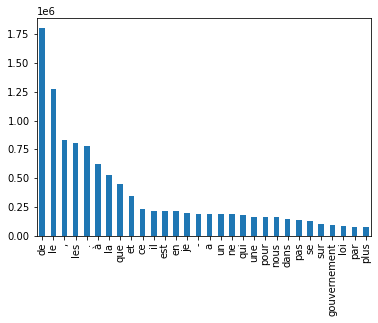

In [22]:
%matplotlib inline
df['French_token'].explode().value_counts()[:30].plot(kind='bar')

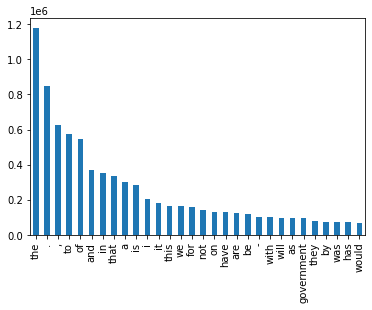

In [23]:
%matplotlib inline
df['English_token'].explode().value_counts()[:30].plot(kind='bar', label='')

In [24]:
print(df.describe())

       English_token_len  French_token_len
count      835272.000000     835272.000000
mean           21.689633         25.571808
std            13.209176         16.054031
min             0.000000          0.000000
25%            12.000000         14.000000
50%            19.000000         22.000000
75%            28.000000         34.000000
max           841.000000        997.000000


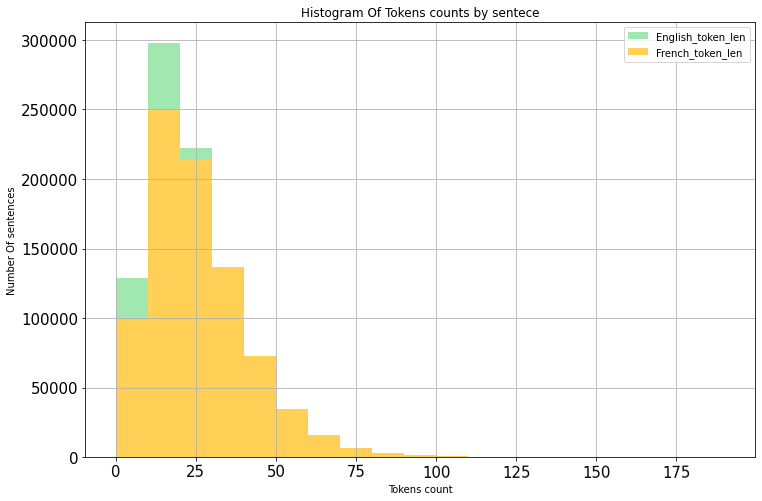

In [25]:
df.plot(kind='hist',
        alpha=1,
        bins=range(0, 200, 10),
        title='Histogram Of Tokens counts by sentece',
        rot=1,
        grid=True,
        figsize=(12,8),
        fontsize=15, 
        color=['#A0E8AF', '#FFCF56'])
plt.xlabel('Tokens count')
plt.ylabel("Number Of sentences");



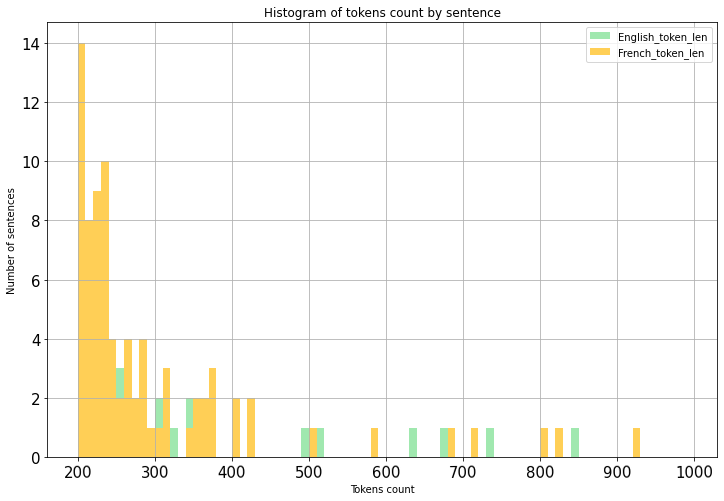

In [26]:
df.plot(kind='hist',
        alpha=1,
        bins=range(200, 1000, 10),
        title='Histogram of tokens count by sentence',
        rot=1,
        grid=True,
        figsize=(12,8),
        fontsize=15, 
        color=['#A0E8AF', '#FFCF56'])
plt.xlabel('Tokens count')
plt.ylabel("Number of sentences");

In [27]:
df['token_diff'] = df['English_token_len'] - df['French_token_len']


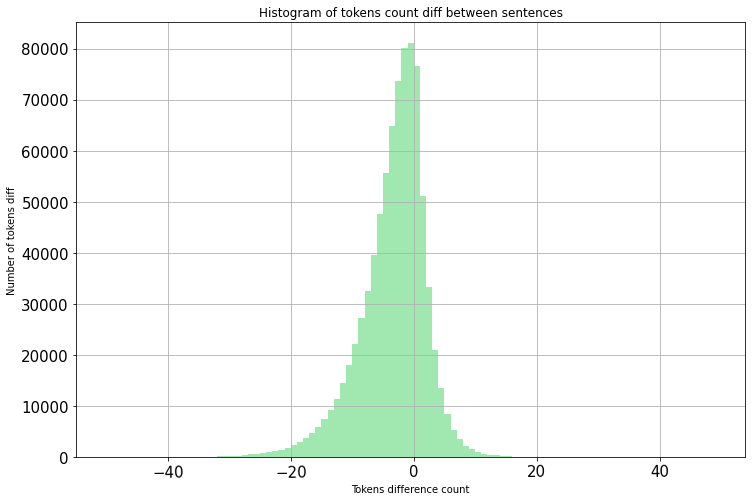

In [28]:
df['token_diff'].plot(kind='hist',
        alpha=1,
        bins=range(-50, 50, 1),
        title='Histogram of tokens count diff between sentences',
        rot=1,
        grid=True,
        figsize=(12,8),
        fontsize=15, 
        color=['#A0E8AF', '#FFCF56'])
plt.xlabel('Tokens difference count')
plt.ylabel("Number of tokens diff");

In [29]:
max_token_len = 30
max_token_diff = 5
df_short = df[ (df['English_token_len'] < max_token_len) & (df['French_token_len'] < max_token_len) ]
print(len(df))

print(len(df_short))
df_short = df_short[ (df_short['token_diff'] < max_token_diff) & (df_short['token_diff'] > - max_token_diff) ]
print(len(df_short))

835272
553700
418388


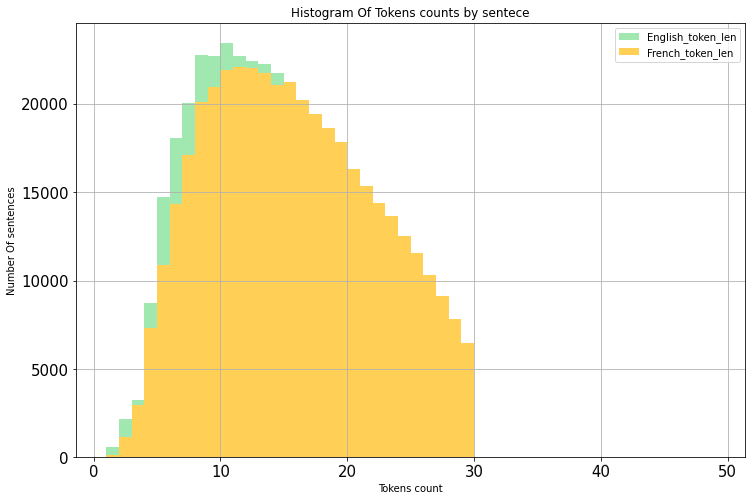

In [30]:
df_short[['English_token_len','French_token_len']].plot(kind='hist',
        alpha=1,
        bins=range(1, 50, 1),
        title='Histogram Of Tokens counts by sentece',
        rot=1,
        grid=True,
        figsize=(12,8),
        fontsize=15, 
        color=['#A0E8AF', '#FFCF56'])
plt.xlabel('Tokens count')
plt.ylabel("Number Of sentences");

In [31]:
#N = len(df_short)
N = 100000
df_small = df_short.iloc[:N,:]

In [32]:
print(len(df))
print(len(df_short))
print(len(df_small))

835272
418388
100000


In [33]:
print(len(df_small['English_token'].explode().value_counts()))
print(len(df_small['French_token'].explode().value_counts()))

21481
29183


#TEST DATA

In [34]:
english_test_file = 'test.e'
french_test_file = 'test.f'
english_test_text = open(english_test_file, encoding='utf8').read().split('\n')
french_test_text = open(french_test_file, encoding='utf8').read().split('\n')

print(len(english_test_text))
print(len(french_test_text))


447
447


In [35]:

#clean gold standard data
import re

#parse_data = lambda x: re.search(">(.*?)</s", x).group(1) if (re.search(">(.*?)</s", x))
gold_test_raw_data = {
            #'Snum': [re.search("<s snum=(.\d*?)>", line).group(1) for line in english_test_text[:]],
            'English': [re.search("<s snum=\d*> (.+?)( <\/s>)", line).group(1) for line in english_test_text[:]],
            'French': [re.search("<s snum=\d*> (.+?)( <\/s>)", line).group(1) for line in french_test_text[:]]}

gold_test= pd.DataFrame(gold_test_raw_data, columns= ['English', 'French'])


gold_test['English_lower'] = gold_test['English'].str.lower()
gold_test['French_lower'] = gold_test['French'].str.lower()
gold_test['English_token'] = gold_test['English_lower'].str.split()
gold_test['French_token'] = gold_test['French_lower'].str.split()

gold_test['English_token_len'] = gold_test['English_token'].apply(len)
gold_test['French_token_len'] = gold_test['French_token'].apply(len)
gold_test['token_diff'] = gold_test['English_token_len'] - gold_test['French_token_len']

gold_test.head(10)

,English,French,English_lower,French_lower,English_token,French_token,English_token_len,French_token_len,token_diff
0,2 .,2 .,2 .,2 .,"[2, .]","[2, .]",2,2,0
1,2 .,2 .,2 .,2 .,"[2, .]","[2, .]",2,2,0
2,"oh , oh !","oh , oh !","oh , oh !","oh , oh !","[oh, ,, oh, !]","[oh, ,, oh, !]",4,4,0
3,"oh , oh !","oh , oh !","oh , oh !","oh , oh !","[oh, ,, oh, !]","[oh, ,, oh, !]",4,4,0
4,"oh , oh !","oh , oh !","oh , oh !","oh , oh !","[oh, ,, oh, !]","[oh, ,, oh, !]",4,4,0
5,"let us remember , Mr. Speaker , that these seg...","souvenons - nous , monsieur le Orateur , que c...","let us remember , mr. speaker , that these seg...","souvenons - nous , monsieur le orateur , que c...","[let, us, remember, ,, mr., speaker, ,, that, ...","[souvenons, -, nous, ,, monsieur, le, orateur,...",20,25,-5
6,"hear , hear !",bravo !,"hear , hear !",bravo !,"[hear, ,, hear, !]","[bravo, !]",4,2,2
7,"hear , hear !",bravo !,"hear , hear !",bravo !,"[hear, ,, hear, !]","[bravo, !]",4,2,2
8,"Mr. Speaker , my question is directed to the M...","monsieur le Orateur , ma question se adresse à...","mr. speaker , my question is directed to the m...","monsieur le orateur , ma question se adresse à...","[mr., speaker, ,, my, question, is, directed, ...","[monsieur, le, orateur, ,, ma, question, se, a...",13,16,-3
9,both have many years experience in the manufac...,tous deux possèdent de nombreuses années de ex...,both have many years experience in the manufac...,tous deux possèdent de nombreuses années de ex...,"[both, have, many, years, experience, in, the,...","[tous, deux, possèdent, de, nombreuses, années...",14,19,-5


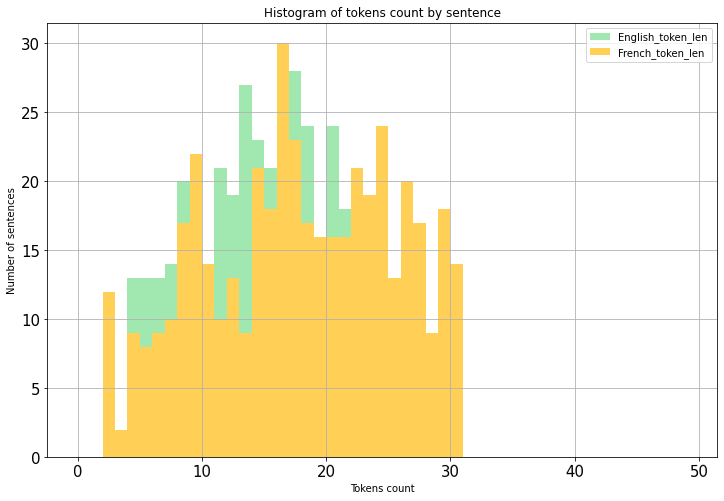

In [36]:
gold_test[['English_token_len','French_token_len']].plot(kind='hist',
        alpha=1,
        bins=range(0, 50, 1),
        title='Histogram of tokens count by sentence',
        rot=1,
        grid=True,
        figsize=(12,8),
        fontsize=15, 
        color=['#A0E8AF', '#FFCF56'])
plt.xlabel('Tokens count')
plt.ylabel("Number of sentences");

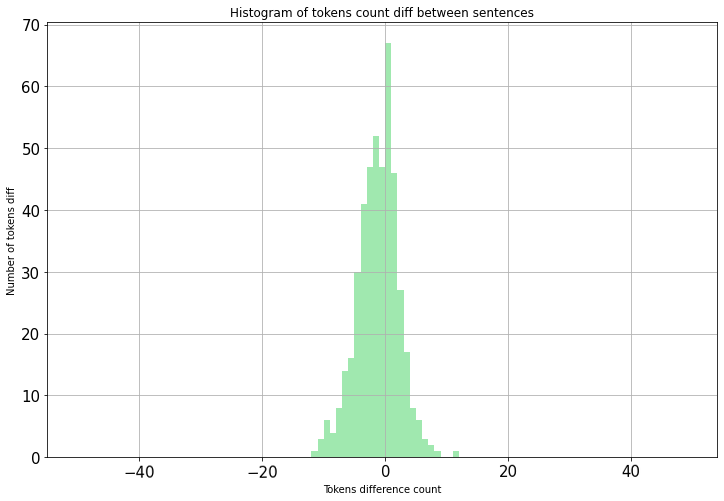

In [37]:
gold_test['token_diff'].plot(kind='hist',
        alpha=1,
        bins=range(-50, 50, 1),
        title='Histogram of tokens count diff between sentences',
        rot=1,
        grid=True,
        figsize=(12,8),
        fontsize=15, 
        color=['#A0E8AF', '#FFCF56'])
plt.xlabel('Tokens difference count')
plt.ylabel("Number of tokens diff");

Field ens permet processar les dades d'una forma homogenia.
Podem indicar la funció per tokenitzar inputs i outputs, tokens inici i final de sequencia, pad tokens per omplir els vectors i incloure la longitud dels inputs. Aquest ultim camp canviara el batch a una tuple (batchs, longituds) on el primer element es un tensor amb els tokens del input i el segon element la longitud.

In [38]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = True)

TRG = Field(tokenize = tokenize_fr, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)


Dividim les dades d'entrenament per fer crossvalidation

In [39]:
train, valid = train_test_split(df_small, test_size = 0.3)

Transformem dades al format json per poder utilitzar la funció tabular datasets per generar les dades en el format correcte mitjançant fields. 

In [40]:
train.to_json('train.json', orient='records', lines=True)
valid.to_json('valid.json', orient='records', lines=True)
gold_test.to_json('test.json', orient='records', lines=True)

In [41]:
#%cd working
#%ls

In [42]:
fields={'English': ('src', SRC), 'French': ('trg', TRG)}

In [43]:
train_data, valid_data, test_data = TabularDataset.splits(
    path='',
    train= 'train.json',
    validation= 'valid.json',
    test='test.json',
    format='json',
    fields=fields)

I construim el vocabulari. Per grans datasets cal reduir el conjunt de vocabulari o les capes d'embedding seran massa grans. Min freq. entre 2 i 20 dona vocabularis d'entre 2000 i 20000 depenen de la mida del dataset d'entrenament.

In [44]:
MIN_FREQUENCY = 10
SRC.build_vocab(train_data, min_freq = MIN_FREQUENCY)
TRG.build_vocab(train_data, min_freq = MIN_FREQUENCY)

In [45]:
src_len = len(SRC.vocab)
trg_len = len(TRG.vocab)

In [46]:
print(src_len)
print(trg_len)

4723
5450


In [47]:
#save model vocab
#%cd /gdrive
src_vocab_name = f'SRC_N{N}_vocab{src_len}_freq{MIN_FREQUENCY}'
SRC_PATH = f'{src_vocab_name}'
torch.save(SRC.vocab, SRC_PATH)

trg_vocab_name = f'TRG_N{N}_vocab{trg_len}_freq{MIN_FREQUENCY}'
TRG_PATH = f'{trg_vocab_name}'
torch.save(TRG.vocab, TRG_PATH)

In [48]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

70000
30000
447


In [49]:
print(train_data.examples[0].src)
print(train_data.examples[0].trg)

['people', 'were', 'wonderful', '.']
['les', 'gens', 'sont', 'merveilleux', '.']


Define device and create iterators.

In [50]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     
     sort=False, 
     
     device = device)

cuda


In [51]:
print(len(train_iterator) )

2188


## Building the Model

### Encoder

Definim el encoder. 
Embeding
RNN Bidireccional
Linear out
Vigilem les mides dels tensors en cada pas

In [52]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
 
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

Calculem l'atenció i apliquem softmax

In [53]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

### Decoder

Embeding
GRU direcional
Linear out

Calcular vector de pes w

In [54]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]

        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

Afegim padding, mascaras i la longitud de les sequencies


Guardem els vectors d'atenció en la matriu attention

Inferencia amb forced teaching

In [55]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
 
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not

            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

## Training the Seq2Seq Model

Next up, initializing the model and placing it on the GPU.

In [56]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 64
DEC_EMB_DIM = 64
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

Init model parameters.

In [57]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.02)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(4723, 64)
    (rnn): GRU(64, 64, bidirectional=True)
    (fc): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=192, out_features=64, bias=True)
      (v): Linear(in_features=64, out_features=1, bias=False)
    )
    (embedding): Embedding(5450, 64)
    (rnn): GRU(192, 64)
    (fc_out): Linear(in_features=256, out_features=5450, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Nombre de parametre del model

In [58]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,171,850 trainable parameters


Optimitzador Adam

Loss function cross entropy

In [59]:
optimizer = optim.Adam(model.parameters())

In [60]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Training i validació

In [61]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        start_time = time.time()

        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()

        end_time = time.time()
        total_time = end_time - start_time
        
        epoch_loss += loss.item()
        if i%100 == 0:
          print(f"Epoch Step: {i} Batch Loss: {loss.item():.3f} Batch Time: {total_time:.3f} s")
        
    return epoch_loss / len(iterator)

In [62]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Then, we'll define a useful function for timing how long epochs take.

In [63]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Entrenem el model

In [64]:
#%cd ~
#import gc
#gc.collect()

In [65]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

val_losses = []
train_losses = []


for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_epoch = epoch
        torch.save(model.state_dict(), 'rnn-model.pt')
        #path = f"{model_save_name}" 
        #torch.save(model.state_dict(), path)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)

    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
print(f'Best epoch: {best_valid_epoch + 1}')

Epoch Step: 0 Batch Loss: 8.603 Batch Time: 0.299 s
Epoch Step: 100 Batch Loss: 5.379 Batch Time: 0.038 s
Epoch Step: 200 Batch Loss: 5.638 Batch Time: 0.035 s
Epoch Step: 300 Batch Loss: 5.208 Batch Time: 0.043 s
Epoch Step: 400 Batch Loss: 5.168 Batch Time: 0.039 s
Epoch Step: 500 Batch Loss: 5.261 Batch Time: 0.045 s
Epoch Step: 600 Batch Loss: 4.596 Batch Time: 0.028 s
Epoch Step: 700 Batch Loss: 5.031 Batch Time: 0.046 s
Epoch Step: 800 Batch Loss: 4.994 Batch Time: 0.044 s
Epoch Step: 900 Batch Loss: 5.024 Batch Time: 0.052 s
Epoch Step: 1000 Batch Loss: 4.557 Batch Time: 0.036 s
Epoch Step: 1100 Batch Loss: 5.075 Batch Time: 0.052 s
Epoch Step: 1200 Batch Loss: 4.378 Batch Time: 0.044 s
Epoch Step: 1300 Batch Loss: 3.966 Batch Time: 0.023 s
Epoch Step: 1400 Batch Loss: 4.560 Batch Time: 0.054 s
Epoch Step: 1500 Batch Loss: 4.849 Batch Time: 0.075 s
Epoch Step: 1600 Batch Loss: 4.727 Batch Time: 0.069 s
Epoch Step: 1700 Batch Loss: 4.153 Batch Time: 0.042 s
Epoch Step: 1800 Batch

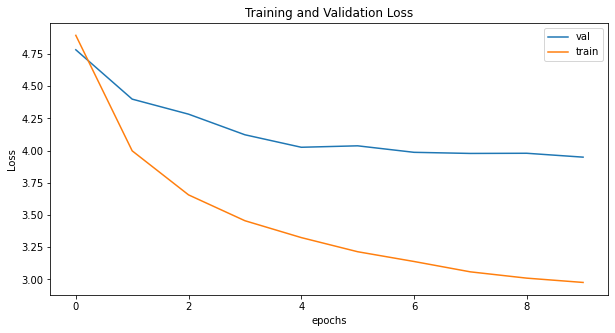

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


Carreguem els millors resultats de l'entrenament

In [67]:
#%cd ~
model.load_state_dict(torch.load('rnn-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)
perplexity = math.exp(test_loss)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {perplexity:7.3f} |')

| Test Loss: 4.513 | Test PPL:  91.189 |


## Predicions

In [68]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
      
        nlp = spacy.load('en_core_web_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [69]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    if isinstance(sentence, str):
        nlp = spacy.load('en_core_web_sm')
        sentence = [token.text.lower() for token in nlp(sentence)]
    else:
        sentence = [token.lower() for token in sentence]

    if isinstance(translation, str):
        nlp = spacy.load('fr_core_news_sm')
        translation = [token.text.lower() for token in nlp(translation)]
    else:
        translation = [token.lower() for token in translation]
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=90)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

## Visualitzation of src trg and attention matrix


src = ['oh', ',', 'oh', '!']
trg = ['oh', ',', 'oh', '!']
4
4
predicted trg = ['oh', '!', '<eos>']


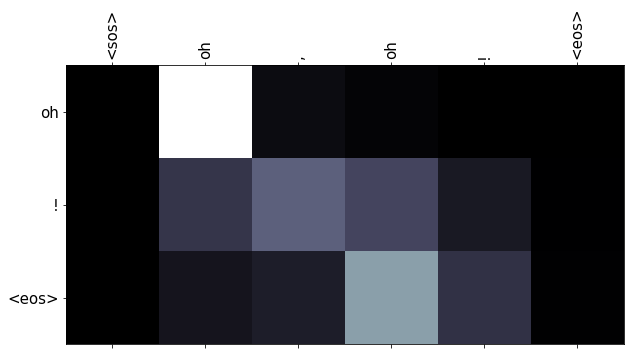

In [70]:
example_idx = 2

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']
print(f'src = {src}')
print(f'trg = {trg}')
print(len(src))
print(len(trg))
translation, attention = translate_sentence(src, SRC, TRG, model, device)


print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

src = ['there', 'is', 'one', 'other', 'point', 'i', 'should', 'like', 'to', 'make', ',', 'and', 'i', 'do', 'so', 'as', 'i', 'feel', 'this', 'is', 'a', 'general', 'debate', '.']
trg = ['je', 'voudrais', 'préciser', 'un', 'autre', 'point', ',', 'et', 'je', 'le', 'fais', 'parce', 'que', 'je', 'estime', 'que', 'il', 'se', 'agit', 'de', 'un', 'débat', 'général', '.']
predicted trg = ['je', 'dois', 'faire', 'un', 'autre', 'point', ',', 'je', 'dois', 'faire', ',', 'je', 'je', 'je', 'suis', 'je', ',', 'je', 'je', 'suis', 'un', 'débat', '.', '<eos>']


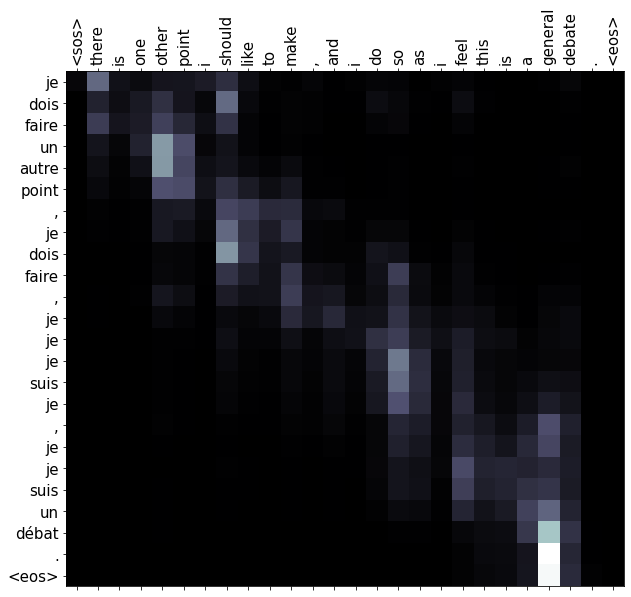

In [71]:
example_idx = 50

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'src = {src}')
print(f'trg = {trg}')
print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

## BLEU

Utilitzem funció bleu_score de torchtext

In [72]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    i=0
    for datum in data:
        src = datum.src
        trg = datum.trg
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [73]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)
print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 12.80


In [74]:
bleu_result = F'{bleu_score*100:.2f}'
test_loss_result = F'{test_loss:.2f}'
print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 12.80


Guardem el model

In [75]:
#save model weigths

#model_name = f'TFG_RNN_N{N}_bleu{bleu_result}_testloss{test_loss_result}_vocab{len(SRC.vocab)}_{len(TRG.vocab)}.pt'
model_name = f'TFG_RNN_{N}_temp_vocab{len(SRC.vocab)}_{len(TRG.vocab)}.pt'
path = f"{model_name}" 
torch.save(model.state_dict(), path)

# Gold standard scores AER 

In [76]:
!ls

requirements.txt	      TFG_RNN_100000_temp_vocab4723_5450.pt
rnn-model.pt		      training.e
sample_data		      training.f
SRC_N100000_vocab4723_freq10  train.json
test.e			      TRG_N100000_vocab5450_freq10
test.f			      valid.json
test.json		      wa_check_align.pl
test.wa.nonullalign	      wa_eval_align.pl


In [77]:
nonullalign_test_file = 'test.wa.nonullalign'

nonullalign_test_text = open(nonullalign_test_file, encoding='utf8').read().split('\n')

In [78]:
colnames=['Snum', 'src_token', 'trg_token', 'Probability'] 
df_nonullalign = pd.read_csv(nonullalign_test_file, names=colnames, header=None, sep = '\s+') 
df_nullalign = pd.read_csv(nonullalign_test_file, names=colnames, header=None, sep = '\s+') 

In [79]:
df_nonullalign.head()

,Snum,src_token,trg_token,Probability
0,1,1,1,S
1,1,2,2,S
2,2,1,1,S
3,2,2,2,S
4,3,1,1,S


Traducció forçada, per generar les matrius d'atenció sobre el gold standard o test

In [80]:
def translate_force_decode(sentence, target, src_field, trg_field, model, device, max_len = 50):

    model.eval()
    if isinstance(sentence, str):
        nlp = spacy.load('en_core_web_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    if isinstance(target, str):
        nlp = spacy.load('fr_core_news_sm')
        target = [token.text.lower() for token in nlp(target)]
    else:
        target = [token.lower() for token in target]


    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    target = [trg_field.init_token] + target + [trg_field.eos_token]
     
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    trg_indexes = [trg_field.vocab.stoi[token] for token in target]

    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[i]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        #pred_token = output.argmax(1).item()
        
        #trg_indexes.append(pred_token)

        if trg_indexes[i] == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return target[1:], attentions[:len(trg_tokens)-1]

origin src = do not force a moratorium down our throats . 
trg = ne nous forcez pas à accepter un moratoire . 
translation = ['ne', 'ne', 'pas', 'pas', 'un', '<unk>', '<unk>', '.', '<eos>']
forced translation = ['ne', 'nous', 'forcez', 'pas', 'à', 'accepter', 'un', 'moratoire', '.', '<eos>']


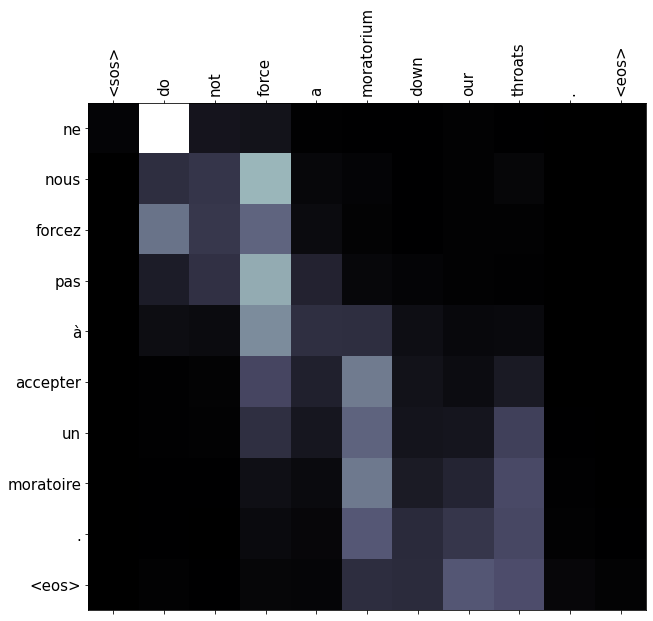

In [81]:
example_idx = 100
# <s snum=0312> let 's think about that for just a moment .  </s>

src = gold_test['English'][example_idx]
trg = gold_test['French'][example_idx]

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'origin src = {src}')
print(f'trg = {trg}')
print(f'translation = {translation}')

#display_attention(src, translation, attention)

translation, attention = translate_force_decode(src, trg, SRC, TRG, model, device)
print(f'forced translation = {translation}')

display_attention(src, translation, attention)


Transformem les atencions en un alineament amb un enfoc greedy

In [82]:
def greedy_sentence_alignment(snum, src, trg, attention, sure_threshold = 0.5, prob_threshold = 0.3, null_threshold = 0.1):
    sentence_result = ''
    attention = attention.squeeze(1).cpu().detach().numpy()
    attention = attention[:-1, 1:-1]
    attx, atty = attention.shape
    snum+=1
    snum_id = f'{snum:04}'

    #max = np.argmax(attention, axis=1) 
    for idx in range(attx):
        #greedy
        best = 0
        current = 0
        trg_tkn = idx + 1
        
        for idy in range(atty):
            current = attention[(idx,idy)]
            src_tkn = idy + 1
            
            if best < current and null_threshold < current:
                best = current
                best_src_tkn = src_tkn
       
                if attention[(idx, idy)] > sure_threshold: 
                    align_prob = "S" 
                else:
                    align_prob="P"
        if best > 0:
            sentence_result += snum_id + " " + str(best_src_tkn) + " " + str(trg_tkn) + " " + align_prob + "\n"
    return sentence_result



Transformem les atencions en un alineament amb un enfoc basat en llindars

In [83]:
def threshold_sentence_alignment(snum, src, trg, attention, sure_threshold = 0.4, prob_threshold = 0.3, null_threshold = 0.1):
    sentence_result = ''
    attention = attention.squeeze(1).cpu().detach().numpy()
    attention = attention[:-1, 1:-1]
    attx, atty = attention.shape
    snum_id = f'{snum:04}'

    #print(attention)
    #print(attention.shape)

    for idx in range(attx):
        matches = 0
        best = 0
        current = 0 
        trg_tkn = idx + 1

        #threshold
        for idy in range(atty):
            current = attention[(idx,idy)]
            src_tkn = idy + 1

            if best < current and null_threshold < current:
                best = current
                best_src_tkn = src_tkn
      
            if attention[(idx, idy)] > sure_threshold: 
                matches+=1
                align_prob = "S"

                sentence_result += snum_id + " " + str(src_tkn) + " " + str(trg_tkn) + " " + align_prob + "\n"

            if sure_threshold > attention[(idx, idy)] and attention[(idx, idy)]  > prob_threshold: 
                matches+=1
                align_prob = "P" 
                sentence_result += snum_id + " " + str(src_tkn) + " " + str(trg_tkn) + " " + align_prob + "\n"

            #if no match, try greedy aproach
        if matches == 0:
            align_prob = "P" 
            sentence_result += snum_id + " " + str(best_src_tkn) + " " + str(trg_tkn) + " " + align_prob + "\n"


    return sentence_result



origin src = that is one major problem . 
trg = il se agit de un problème important . 
translation = ['ce', 'est', 'un', 'problème', 'problème', '.', '<eos>']
forced translation = ['il', 'se', 'agit', 'de', 'un', 'problème', 'important', '.', '<eos>']


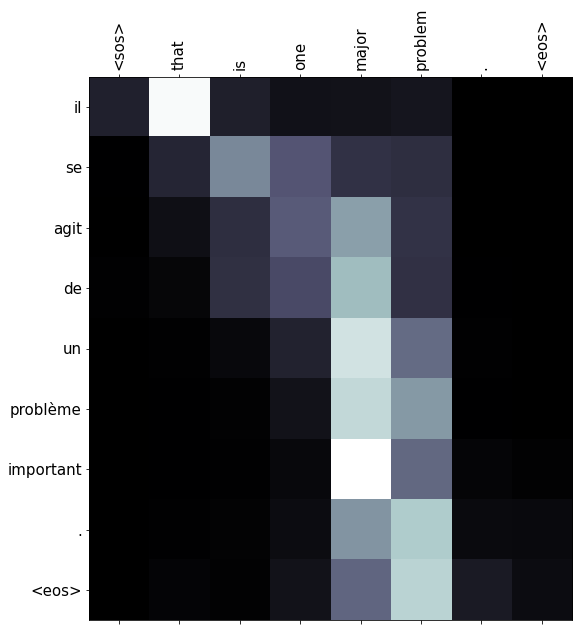

In [84]:
example_idx = 379
# <s snum=0312> let 's think about that for just a moment .  </s>

src = gold_test['English'][example_idx - 1]
trg = gold_test['French'][example_idx - 1]

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'origin src = {src}')
print(f'trg = {trg}')
print(f'translation = {translation}')

#display_attention(src, translation, attention)

translation, attention = translate_force_decode(src, trg, SRC, TRG, model, device)
print(f'forced translation = {translation}')

display_attention(src, translation, attention)

In [85]:

ouput = greedy_sentence_alignment(example_idx, src, trg, attention)
print(src)
print(trg)
print(ouput)

that is one major problem . 
il se agit de un problème important . 
0380 1 1 S
0380 2 2 P
0380 4 3 P
0380 4 4 P
0380 4 5 S
0380 4 6 S
0380 4 7 S
0380 5 8 P



In [86]:

ouput = threshold_sentence_alignment(example_idx, src, trg, attention)
print(src)
print(trg)
print(ouput)

that is one major problem . 
il se agit de un problème important . 
0379 1 1 S
0379 2 2 P
0379 4 3 S
0379 4 4 S
0379 4 5 S
0379 4 6 S
0379 5 6 P
0379 4 7 S
0379 4 8 P
0379 5 8 S



In [87]:
ouput = threshold_sentence_alignment(example_idx, src, trg, attention)
print(src)
print(ouput)

that is one major problem . 
0379 1 1 S
0379 2 2 P
0379 4 3 S
0379 4 4 S
0379 4 5 S
0379 4 6 S
0379 5 6 P
0379 4 7 S
0379 4 8 P
0379 5 8 S



In [88]:
example_idx = 378
# <s snum=0312> let 's think about that for just a moment .  </s>

src = test_data.examples[example_idx].src
trg = test_data.examples[example_idx].trg

translation, attention = translate_force_decode(src, trg, SRC, TRG, model, device)

#print(train_data.examples[0].src)
#print(train_data.examples[0].trg)

ouput = threshold_sentence_alignment(example_idx, src, trg, attention)
print(src, trg)
print(ouput)

['that', 'is', 'one', 'major', 'problem', '.'] ['il', 'se', 'agit', 'de', 'un', 'problème', 'important', '.']
0378 1 1 S
0378 2 2 P
0378 4 3 S
0378 4 4 S
0378 4 5 S
0378 4 6 S
0378 5 6 P
0378 4 7 S
0378 4 8 P
0378 5 8 S



In [89]:
example_idx = 378
# <s snum=0312> let 's think about that for just a moment .  </s>

src = test_data.examples[example_idx].src
trg = test_data.examples[example_idx].trg

translation, attention = translate_force_decode(src, trg, SRC, TRG, model, device)

#print(train_data.examples[0].src)
#print(train_data.examples[0].trg)

ouput = greedy_sentence_alignment(example_idx, src, trg, attention)
print(src, trg)
print(ouput)

['that', 'is', 'one', 'major', 'problem', '.'] ['il', 'se', 'agit', 'de', 'un', 'problème', 'important', '.']
0379 1 1 S
0379 2 2 P
0379 4 3 P
0379 4 4 P
0379 4 5 S
0379 4 6 S
0379 4 7 S
0379 5 8 P



In [90]:
#def translate_force_decode(sentence, target, src_field, trg_field, model, device, max_len = 50):

def file_alignment(src_data, SRC, TRG, model, device, sentence_alignment, prob_threshold = 0.5):
    start_time = time.time()
    results = []
    snum = 0
    index = 0
    for pair in src_data:
        index +=1
        src = pair.src
        trg = pair.trg

        translation, attention = translate_force_decode(src, trg, SRC, TRG, model, device)

        sentence = sentence_alignment(index, src, trg, attention, prob_threshold)
        #print(sentence)
        results.append(sentence)
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Time: {total_time:.3f} s")

    return results



In [91]:

#greedy_results = file_alignment(test_data, SRC, TRG, model, device, greedy_sentence_alignment, prob_threshold = 0.3)

threshold_results = file_alignment(test_data, SRC, TRG, model, device, threshold_sentence_alignment, prob_threshold = 0.3)


Time: 8.237 s


In [92]:
#save submission
#write function TODO

ALIGN_PATH = 'RNN_alignment_submission_file_100000.txt' 


with open(ALIGN_PATH , 'w') as writefile:
    for alignment in threshold_results:
        #print(alignment)
        writefile.write(alignment)

# AER alignment error rates


In [93]:
wa_check_path = 'wa_check_align.pl' 
wa_eval_path = 'wa_eval_align.pl'

wa_check = open(wa_check_path, encoding='utf8')
wa_eval = open(wa_eval_path, encoding='utf8')

In [94]:
%%bash

perl 'wa_check_align.pl' 'RNN_alignment_submission_file_100000.txt' 

File format is OK.


In [95]:
%%bash
perl 'wa_check_align.pl' 'test.wa.nonullalign'

File format is OK.


In [96]:
%%bash
perl 'wa_eval_align.pl' 'test.wa.nonullalign' 'RNN_alignment_submission_file_100000.txt' 


The following results assume correct file formats.
Make sure you have previously checked the file format
using wa_check_submission.pl


    Word Alignment Evaluation   
----------------------------------
   Evaluation of SURE alignments 
   Precision = 0.1676  
   Recall    = 0.2613
   F-measure = 0.2042
-----------------------------------
   Evaluation of PROBABLE alignments
   Precision = 0.4192
   Recall    = 0.2055
   F-measure = 0.2758
-----------------------------------
   AER       = 0.6173


# Compare gold alignment vs attention alignment

In [97]:


alignment_submission_file = 'RNN_alignment_submission_file_100000.txt' 

alignment_submission_text = open(alignment_submission_file, encoding='utf8').read().split('\n')

colnames=['Snum', 'src_token', 'trg_token', 'Probability'] 
df_submissionalign = pd.read_csv(alignment_submission_file, names=colnames, header=None, sep = '\s+') 

len(df_submissionalign)

8550

In [98]:
alignment_gold_file = 'test.wa.nonullalign'

alignment_gold_text = open(alignment_gold_file, encoding='utf8').read().split('\n')

colnames=['Snum', 'src_token', 'trg_token', 'Probability'] 
df_goldalign = pd.read_csv(alignment_gold_file, names=colnames, header=None, sep = '\s+') 

print(len(df_goldalign))

17438


In [99]:
def get_alignment_matrix(src_len, trg_len, id, align_dataframe):
    align_matrix = np.zeros( (src_len,trg_len) )
    align_sentence = align_dataframe(align_dataframe['Snum'] == id)

    for x in range(src_len): 
        for y in range(trg_len):
            prob = align_dataframe['Probability'].where(align_sentence['src_token'] == x and align_sentence['trg_token'] == y)
            if prob == 'S':
                align_matrix[x][y] = 1
            if prob == 'P':
                align_matrix[x][y] = 0.5
    return align_matrix

In [100]:
def display_alignment(src, trg, alignment_matrix):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    cay = ax.matshow(alignment_matrix, cmap='bone')
   
    ax.tick_params(labelsize=15)

    x_ticks = [''] + src
    y_ticks = [''] + trg
     
    ax.set_xticklabels(x_ticks, rotation=90)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

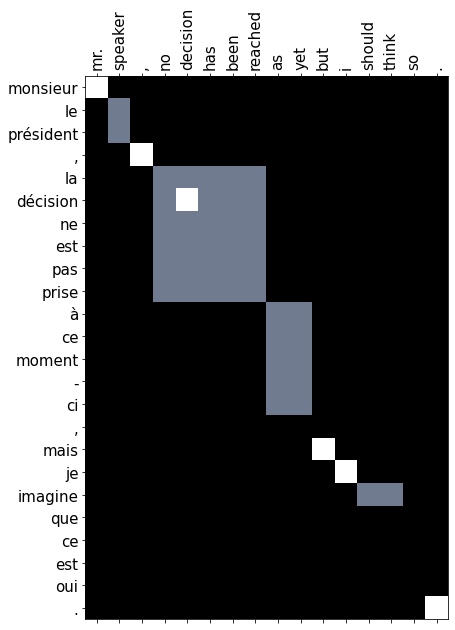

In [106]:
id = 37
align_dataframe = df_goldalign


src = gold_test['English_token'][id]
trg = gold_test['French_token'][id]

src_len = gold_test['English_token_len'][id]
trg_len = gold_test['French_token_len'][id]
#print(trg, src)

#print(trg_len, src_len)
alignment_matrix = np.zeros( (trg_len, src_len) )
#print(alignment_matrix)

snum_align_dataframe = align_dataframe.set_index(['Snum'])

snum_align_dataframe_id = snum_align_dataframe.loc[id+1]
#print(snum_align_dataframe_id)

for index, row in snum_align_dataframe_id.iterrows():
    x = row['trg_token']-1
    y = row['src_token']-1
    if row['Probability'] == 'S':
        value = 1.0
    if row['Probability'] == 'P':
        value = 0.5
    #print(x,y,value)
    alignment_matrix[x,y] = value

#print(alignment_matrix)
display_alignment(src, trg, alignment_matrix)


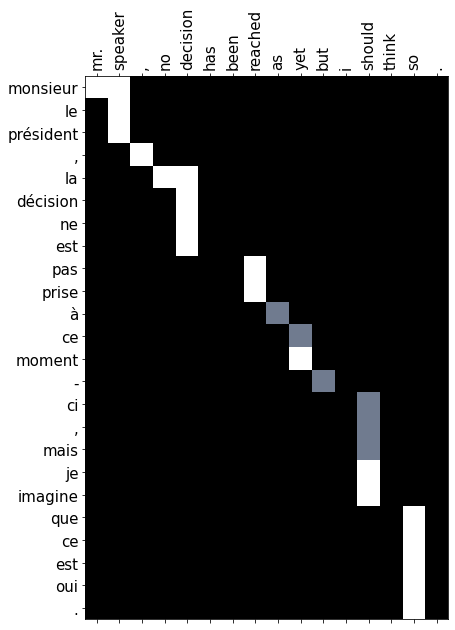

In [107]:
id = 37
align_dataframe = df_submissionalign


src = gold_test['English_token'][id]
trg = gold_test['French_token'][id]

src_len = gold_test['English_token_len'][id]
trg_len = gold_test['French_token_len'][id]
#print(src, trg)

#print(trg_len,src_len)
alignment_matrix = np.zeros( (trg_len, src_len) )
#print(alignment_matrix)

snum_align_dataframe = align_dataframe.set_index(['Snum'])

snum_align_dataframe_id = snum_align_dataframe.loc[id+1]
#print(snum_align_dataframe_id)

for index, row in snum_align_dataframe_id.iterrows():
    x = row['trg_token']-1
    y = row['src_token']-1
    if row['Probability'] == 'S':
        value = 1.0
    if row['Probability'] == 'P':
        value = 0.5
    #print(x,y,value)
    alignment_matrix[x,y] = value

#print(alignment_matrix)
display_alignment(src, trg, alignment_matrix)

origin src = Mr. Speaker , no decision has been reached as yet but I should think so . 
trg = monsieur le président , la décision ne est pas prise à ce moment - ci , mais je imagine que ce est oui . 
translation = ['monsieur', 'le', 'président', ',', 'non', ',', 'il', 'ne', 'a', 'pas', 'été', ',', 'mais', 'je', 'crois', 'que', 'je', 'crois', '.', '<eos>']
forced translation = ['monsieur', 'le', 'président', ',', 'la', 'décision', 'ne', 'est', 'pas', 'prise', 'à', 'ce', 'moment', '-', 'ci', ',', 'mais', 'je', 'imagine', 'que', 'ce', 'est', 'oui', '.', '<eos>']


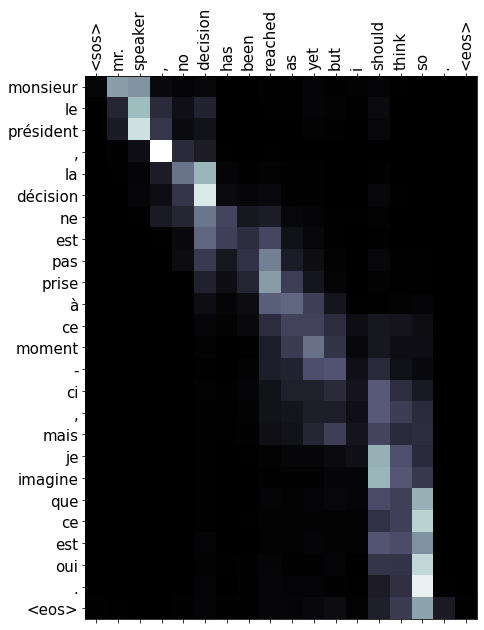

In [109]:
example_idx = 38
# <s snum=0312> let 's think about that for just a moment .  </s>

src = gold_test['English'][example_idx - 1]
trg = gold_test['French'][example_idx - 1]

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'origin src = {src}')
print(f'trg = {trg}')
print(f'translation = {translation}')

#display_attention(src, translation, attention)

translation, attention = translate_force_decode(src, trg, SRC, TRG, model, device)
print(f'forced translation = {translation}')

display_attention(src, translation, attention)

 <a href= 'RNN_alignment_submission_file.txt' > Download submission </a>

 <a href= 'requirements.txt' > Download Requirements </a>
 
 <a href= 'rnn-model.pt' > Download Model </a>


In [104]:
import torch;
torch.__version__

'1.10.0+cu111'